In [16]:
import sys
sys.path.append("../")
sys.path.append("../ride/")

In [17]:
import pickle
from os import listdir
from os.path import isfile, join

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from ride.common import CityResult
from ride import common

In [18]:
plt.rc('legend', fontsize=30)
plt.rcParams.update({'font.size': 30})
plt.rcParams['text.usetex'] = False
plt.style.use({'figure.facecolor': 'white'})

In [21]:
mypath = '../data/results'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

r: dict[str:CityResult] = {}
for name in onlyfiles:
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

In [22]:
nodes = []
max_speed_up = []
for name in r:
    res: CityResult = r[name]
    N = res.nodes


    def f(x, a):
        k = x * (1 + np.log(x) / np.log(N)) + a * x ** 0.5 / x
        return 1 / k


    speed_up = np.array([p.speed_up[0] for p in res.points_results])
    alpha = np.array([p.alpha for p in res.points_results])
    popt = curve_fit(f, alpha, speed_up, p0=[46 / N ** (-0.48)])

    y = f(alpha, *popt[0])
    delta = (y - speed_up) ** 2
    nodes.append(N)
    max_speed_up.append(np.max(y))

In [23]:
plt.rc('legend', fontsize=30)
plt.rcParams.update({'font.size': 30})
plt.rcParams['text.usetex'] = False

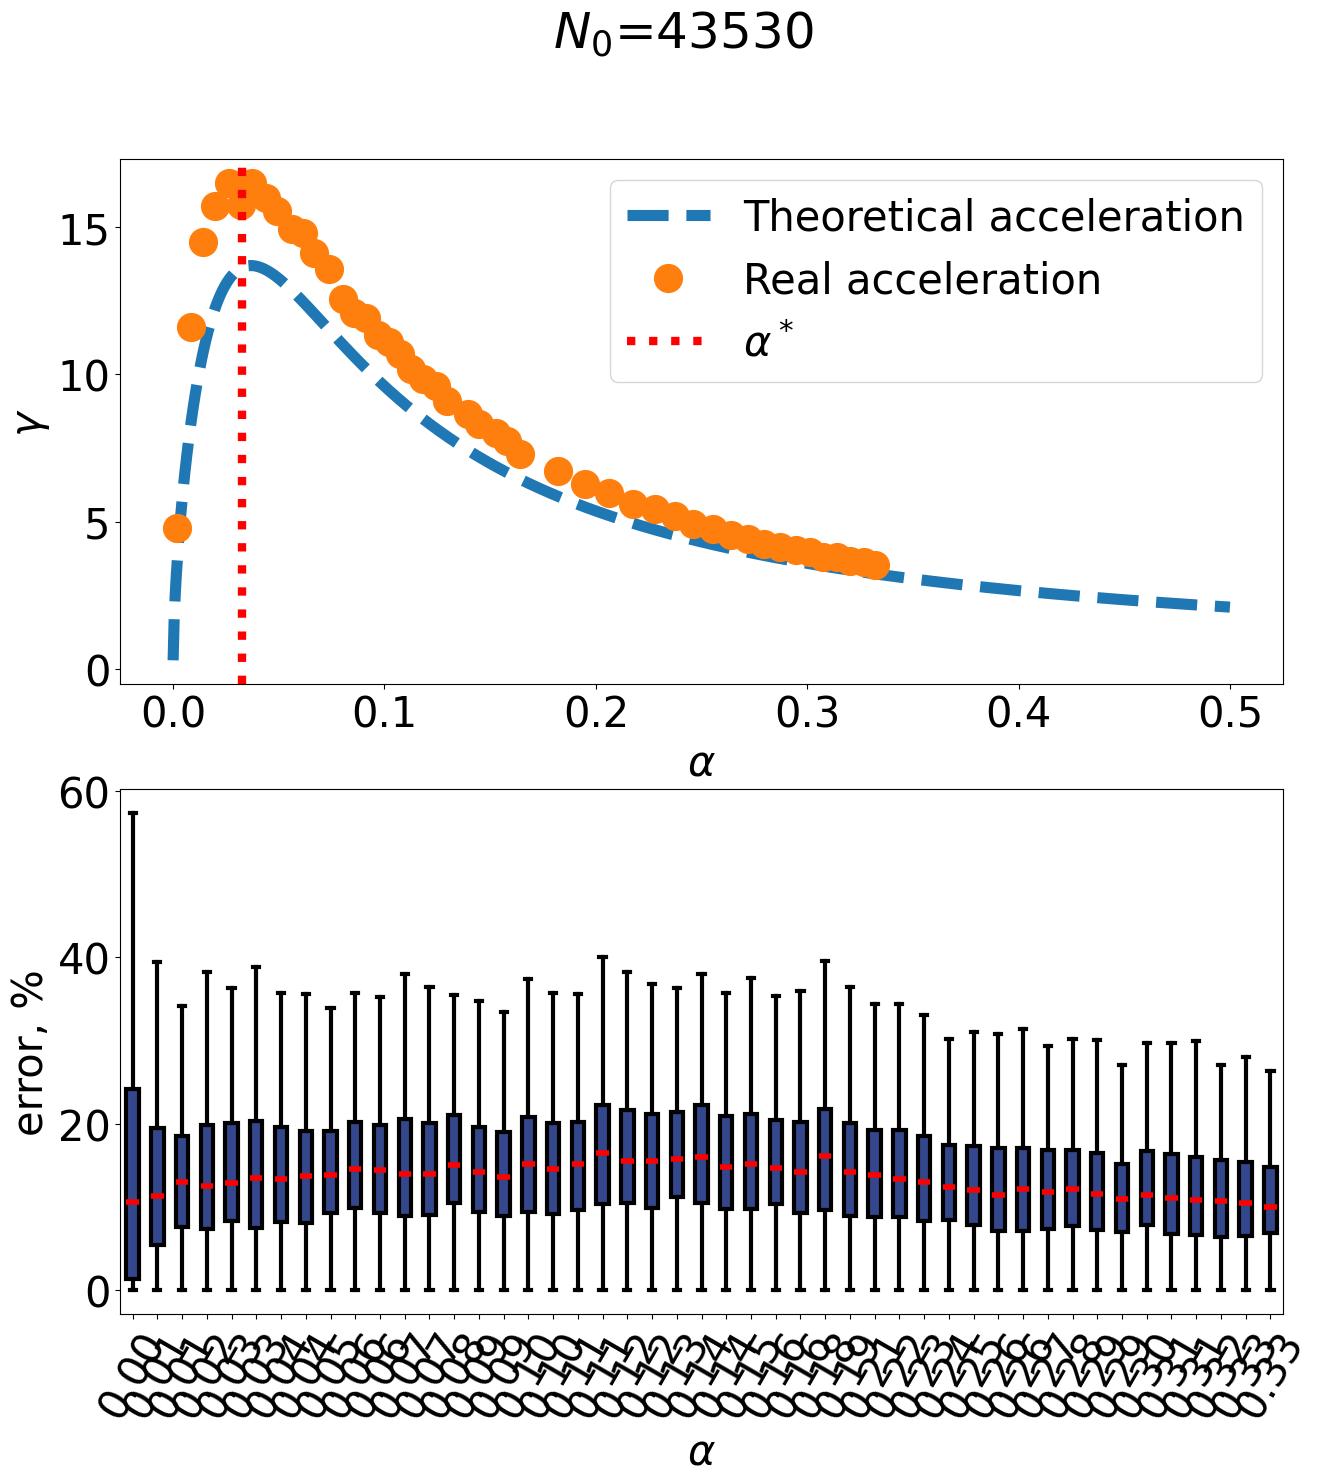

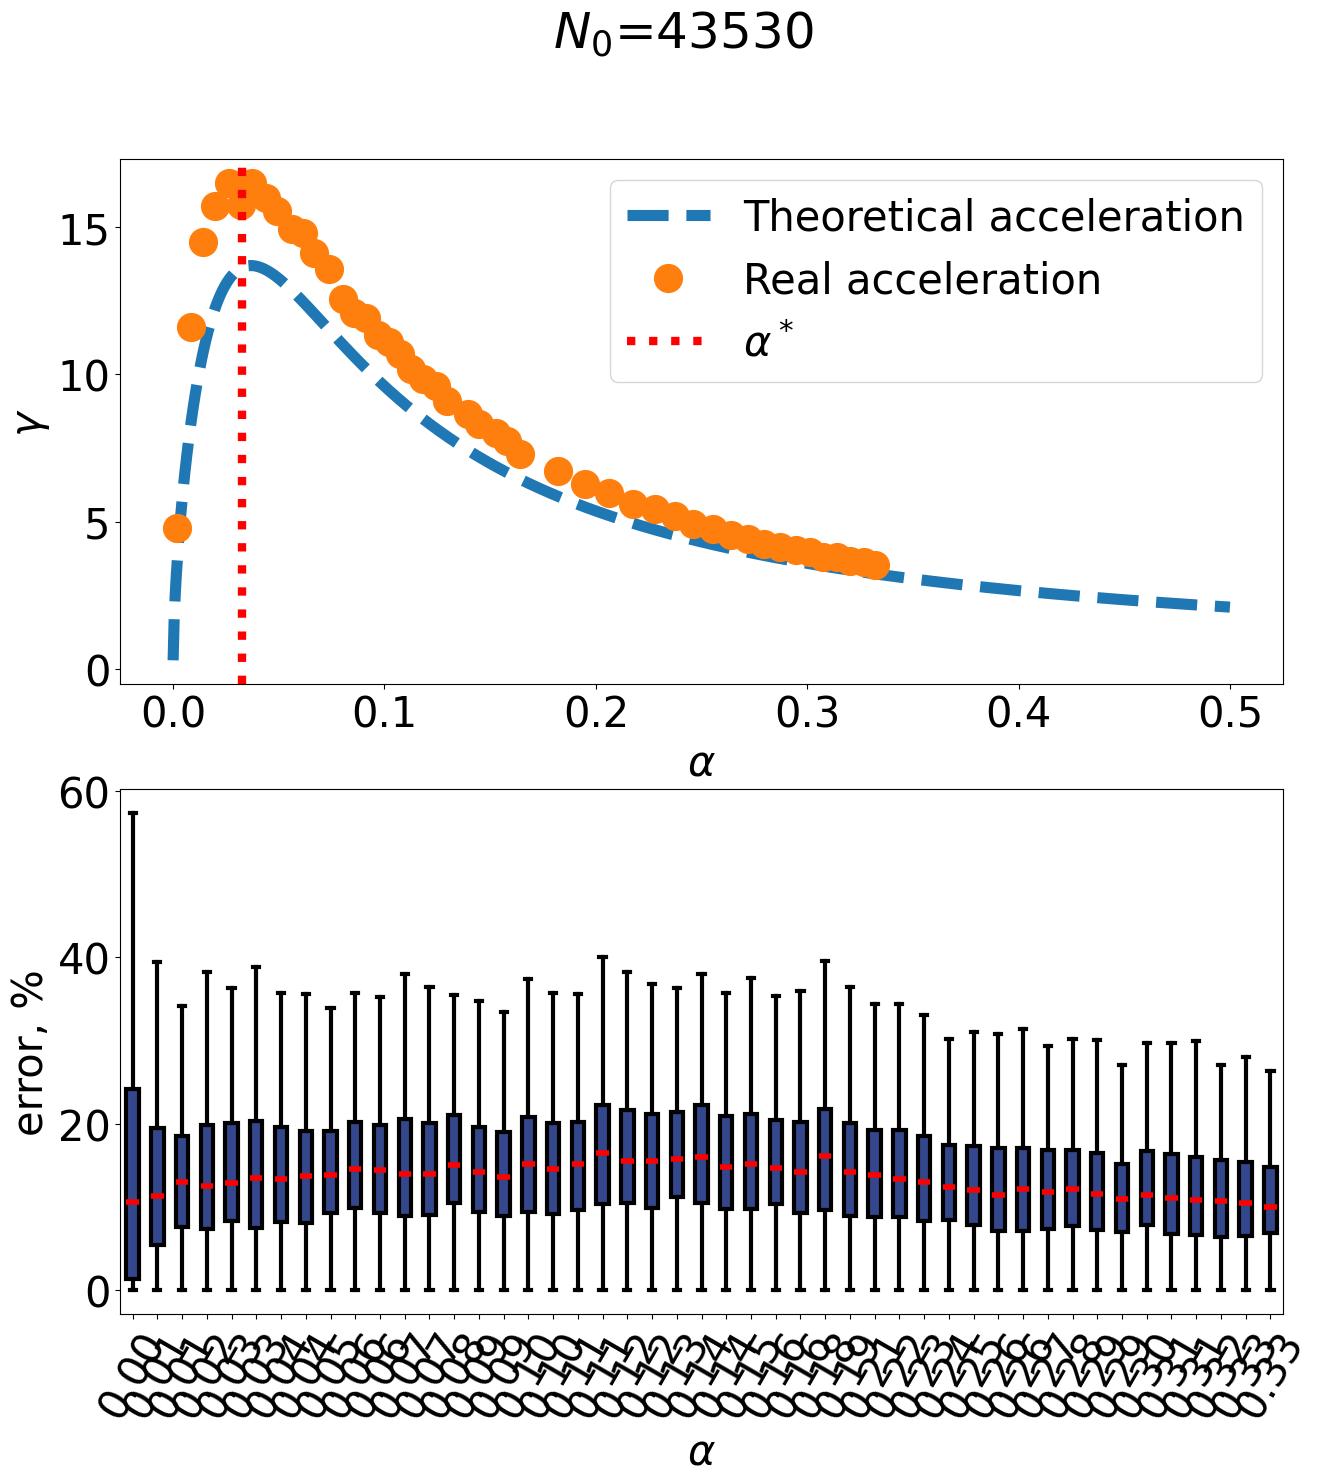

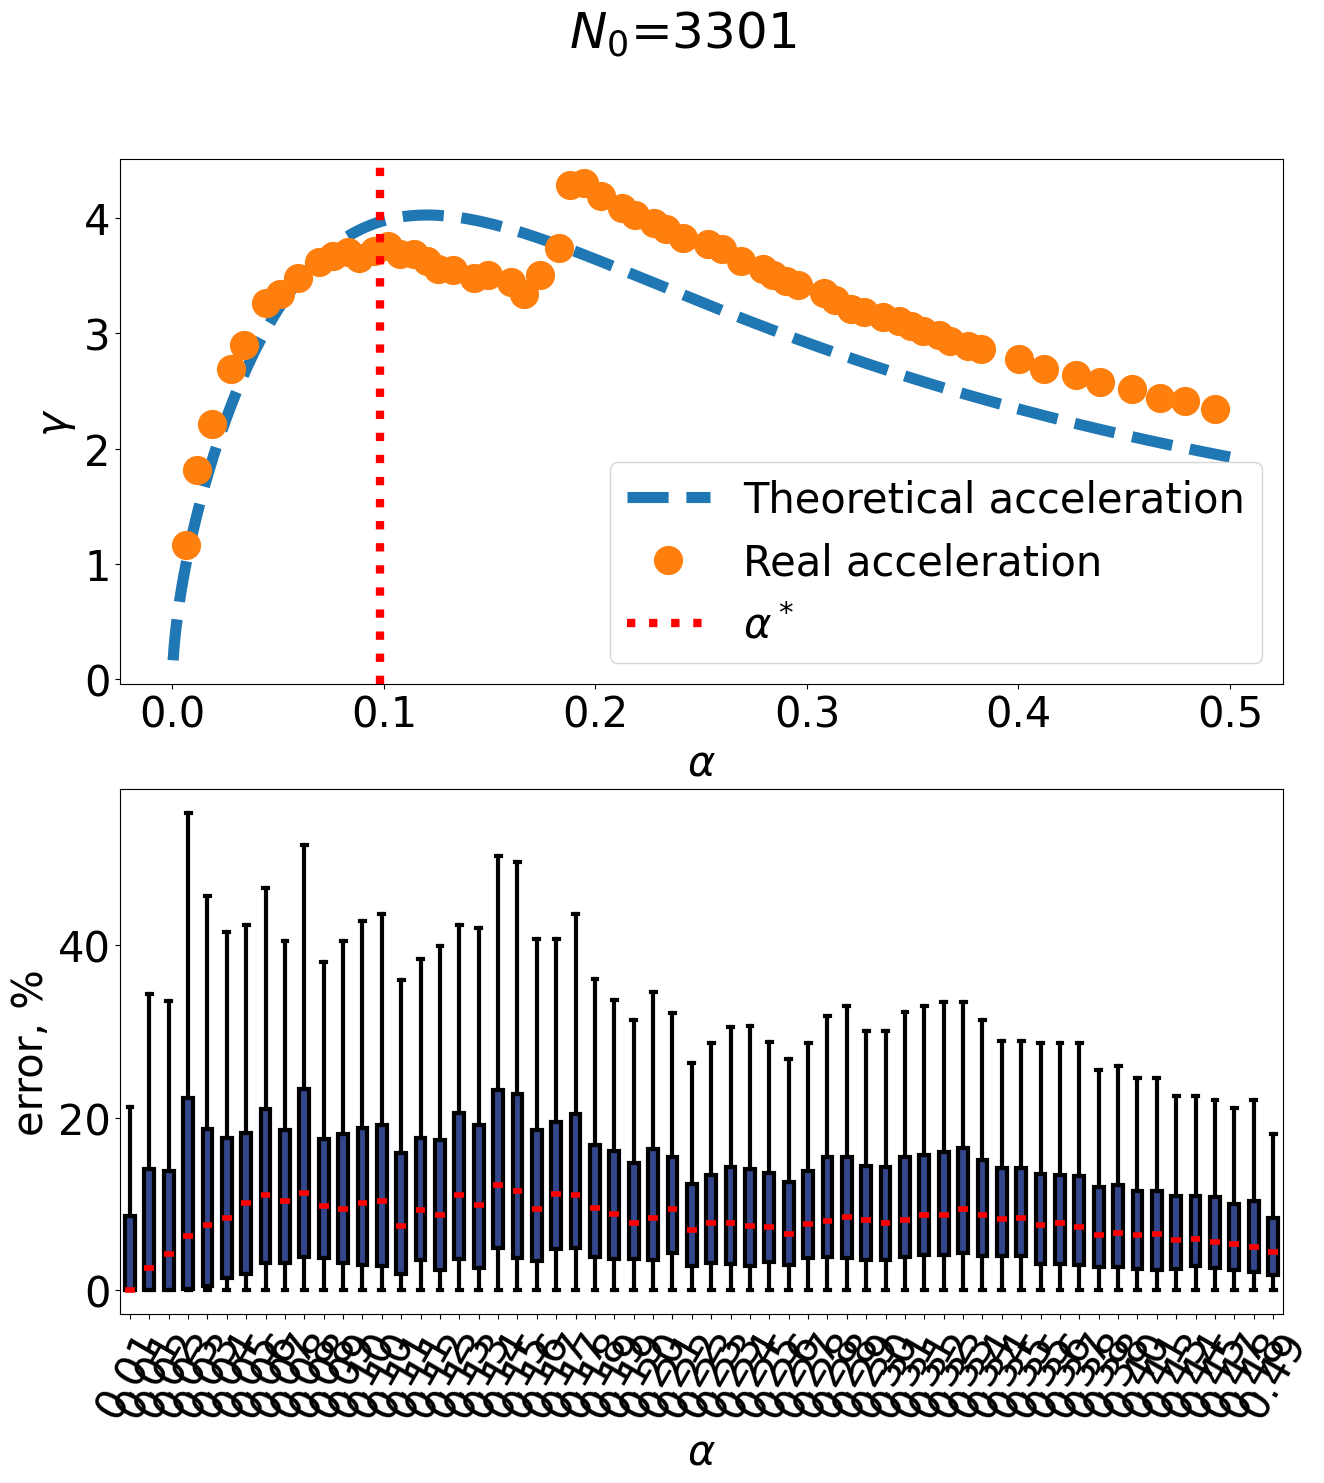

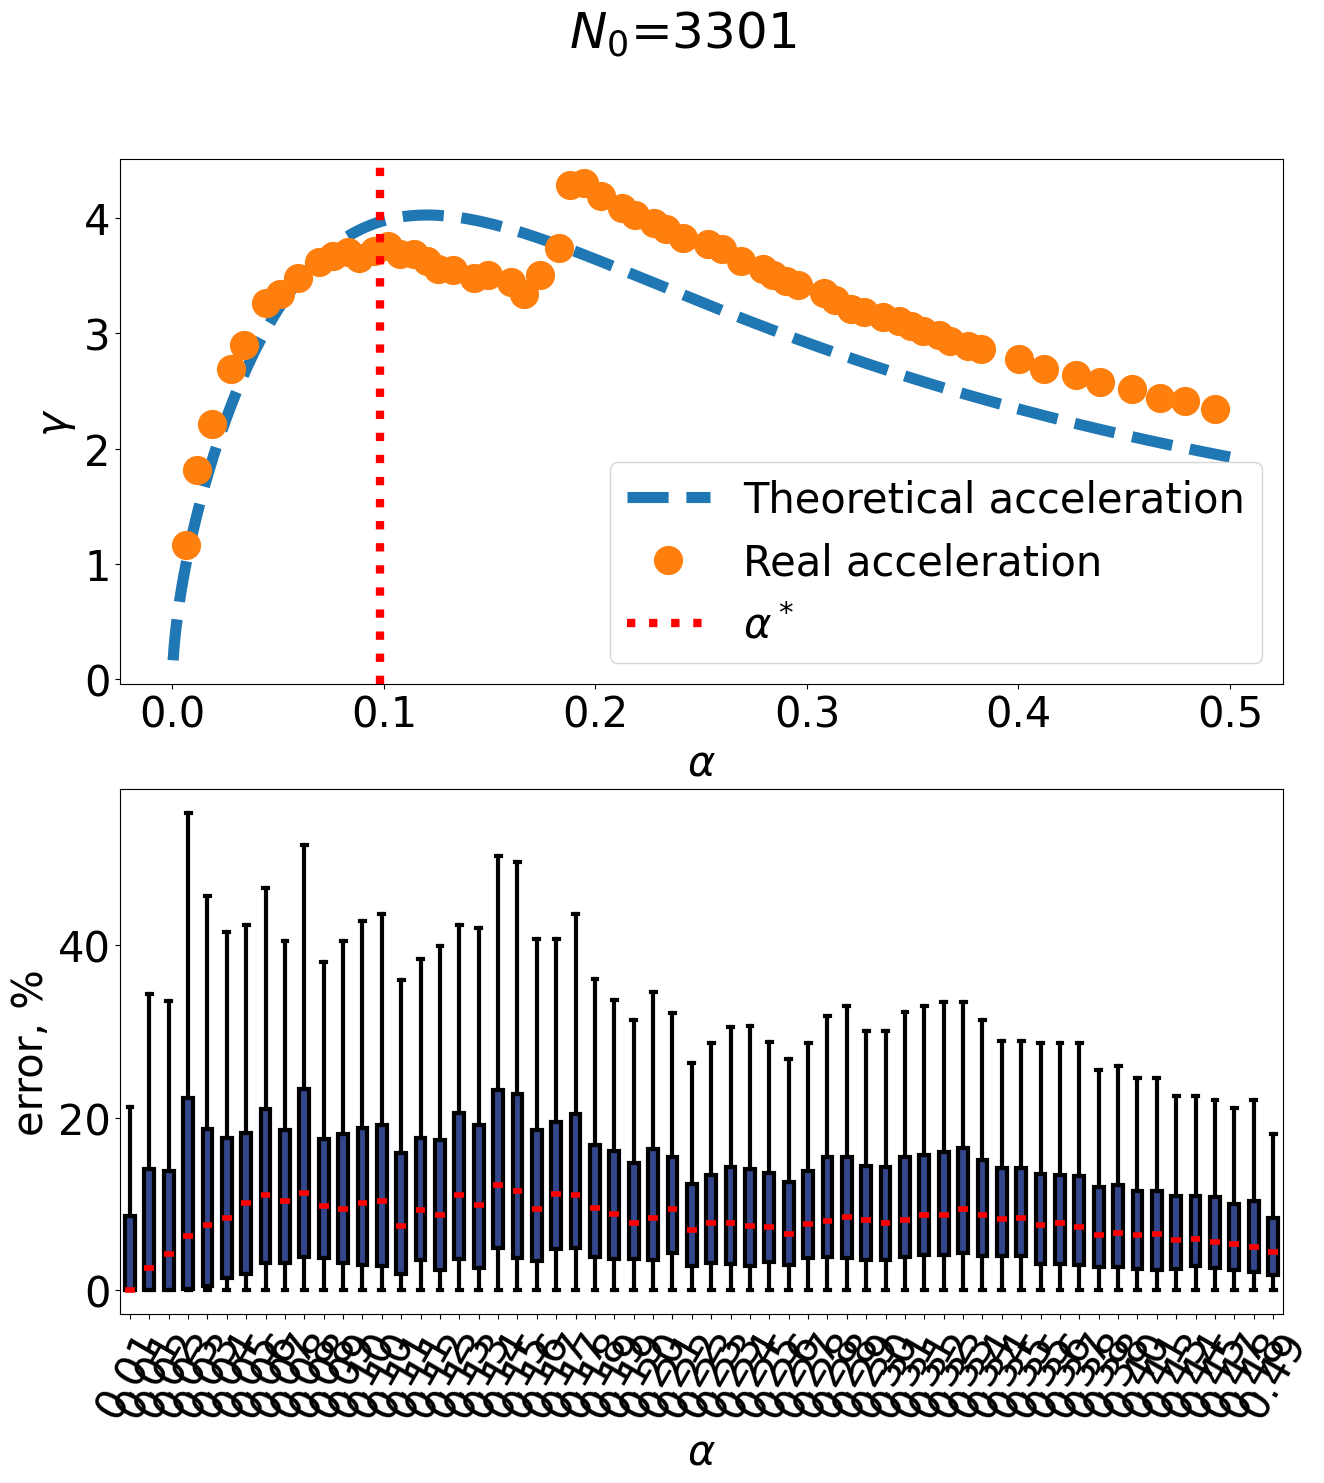

In [24]:
def myround(x, base=10):
    return base * round(x / base)

# Общая функция для расчета теоретического ускорения
def theoretical_acceleration(x, N):
    k = x * (1 + np.log(x) / np.log(N)) + 46 / (N ** 0.72 * x ** 0.5) * (0.28 - np.log(x) / np.log(N) / 2)
    return 1 / k

# Функция для оптимизации ускорения
def optimized_acceleration(x, a, N):
    k = x * (1 + np.log(x) / np.log(N)) + a / x ** 0.5
    return 1 / k

# Функция для форматирования подписей
def format_labels(points_results, alpha_threshold=None):
    if alpha_threshold:
        return ['{:.2f}'.format(myround(p.alpha * 1000) / 1000) for p in points_results if p.alpha <= alpha_threshold]
    else:
        return ['{:.2f}'.format(myround(p.alpha * 1000) / 1000) for p in points_results]

# Функция для отрисовки графика ускорения
def plot_acceleration(ax, alpha, speed_up, N, a0, func, max_alpha):
    alpha1 = np.linspace(1 / N, max_alpha, 1000)
    ax.plot(alpha1, func(alpha1, N), '--', label='Theoretical acceleration', markersize=30, linewidth=8)
    idx = np.argwhere(alpha <= max_alpha)
    ax.plot(alpha[idx], speed_up[idx], 'o', label='Real acceleration', markersize=20)
    ax.axvline(x=a0, ymin=0, c='r', linestyle=':', label=r'$\alpha^*$', linewidth=6)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\gamma$')
    ax.legend()

# Функция для отрисовки боксплота ошибок
def plot_boxplot(ax, points_results, labels):
    boxprops = {"color": "black", "linewidth": 3, "facecolor": "#35478C"}
    medianprops = {"color": "r", "linewidth": 4}
    whiskerprops = {"color": "black", "linewidth": 3}
    capprops = {"color": "black", "linewidth": 3}
    
    errors = [np.array(p.errors) * 100 for p in points_results]
    ax.boxplot(errors, labels=labels, showfliers=False, vert=True, patch_artist=True,
               medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
    ax.tick_params(axis='x', labelrotation=60)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('error, %')

# Основная функция для отрисовки графиков
def plot_city_results(res, N, max_alpha=0.5, alpha_threshold=0.5):
    fig, axs = plt.subplots(2, 1)
    fig.set_figwidth(15)
    fig.set_figheight(15)

    alpha = np.array([p.alpha for p in res.points_results])
    speed_up = np.array([p.speed_up[0] for p in res.points_results])

    # Теоретическое значение alpha*
    a0 = 8.09 * N ** -0.48 * (1 - 19.4 / (4.8 * np.log(N) + 8.8))
    
    # Построение графика ускорения
    plot_acceleration(axs[0], alpha, speed_up, N, a0, theoretical_acceleration, max_alpha)

    # Форматирование лейблов для боксплота
    labels = format_labels(res.points_results, alpha_threshold)

    # Построение боксплота ошибок
    plot_boxplot(axs[1], res.points_results, labels)

    fig.suptitle(fr'$N_0$={N}')
    plt.show()

for i, name in enumerate(r):
    res: CityResult = r[name]
    N = res.nodes
    plot_city_results(res, N)
    plot_city_results(res, N, alpha_threshold=None)


In [25]:
mypath = '../data/results/for_test/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
r: dict[str:CityResult] = {}
for name in onlyfiles:
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

nodes = []
density = []
alpha_opt = []
speed_up_opt = []

for i, name in enumerate(r):
    res: CityResult = r[name]
    N = res.nodes
    M = res.edges


    def func(x, a):
        k = x * (1 + np.log(x) / np.log(N)) + a / (x ** 0.5)
        return 1 / k


    alpha = [p.alpha for p in res.points_results]
    speed_up = [p.speed_up[0] for p in res.points_results]
    alpha = np.array(alpha)
    speed_up = np.array(speed_up)
    
    popt = curve_fit(func, alpha, speed_up)

    xx = np.linspace(1 / N, 1, 1000)
    yy = func(xx, *popt[0])

    nodes.append(N)
    density.append(2 * M / N / (N - 1))
    alpha_opt.append(alpha[np.argmax(speed_up)])
    speed_up_opt.append(max(speed_up))

nodes = np.array(nodes)
density = np.array(density)
alpha_opt = np.array(alpha_opt)
speed_up_opt = np.array(speed_up_opt)

In [26]:
def plot_loglog(x_data, y_data, theoretical_curve, x_label, y_label, legend_real, legend_theoretical, y_limits=None, x_limits=None):
    plt.figure(figsize=(15, 15))
    plt.loglog(x_data, y_data, 'o', label=legend_real, markersize=10, linewidth=8, alpha=0.5)
    
    # Сортируем данные по оси X для теоретической кривой
    x_sorted = np.sort(x_data)
    plt.loglog(x_sorted, theoretical_curve(x_sorted), '--', c='r', label=legend_theoretical, markersize=30, linewidth=8)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if y_limits:
        plt.ylim(y_limits)
    if x_limits:
        plt.xlim(x_limits)
    
    plt.legend()
    plt.show()

In [27]:
def theoretical_max_acceleration_nodes(nodes):
    return 1 / 13 * nodes ** 0.48

def theoretical_max_acceleration_density(density):
    return 1 / 13 * (2.8 / density) ** 0.48

def theoretical_alpha_star_nodes(nodes):
    return 8.09 * nodes ** -0.48 * (1 - 19.4 / (4.8 * np.log(nodes) + 8.8))

def theoretical_alpha_star_density(density):
    return 8.09 * (2.8 / density) ** -0.48 * (1 - 19.4 / (4.8 * np.log(2.8 / density) + 8.8))

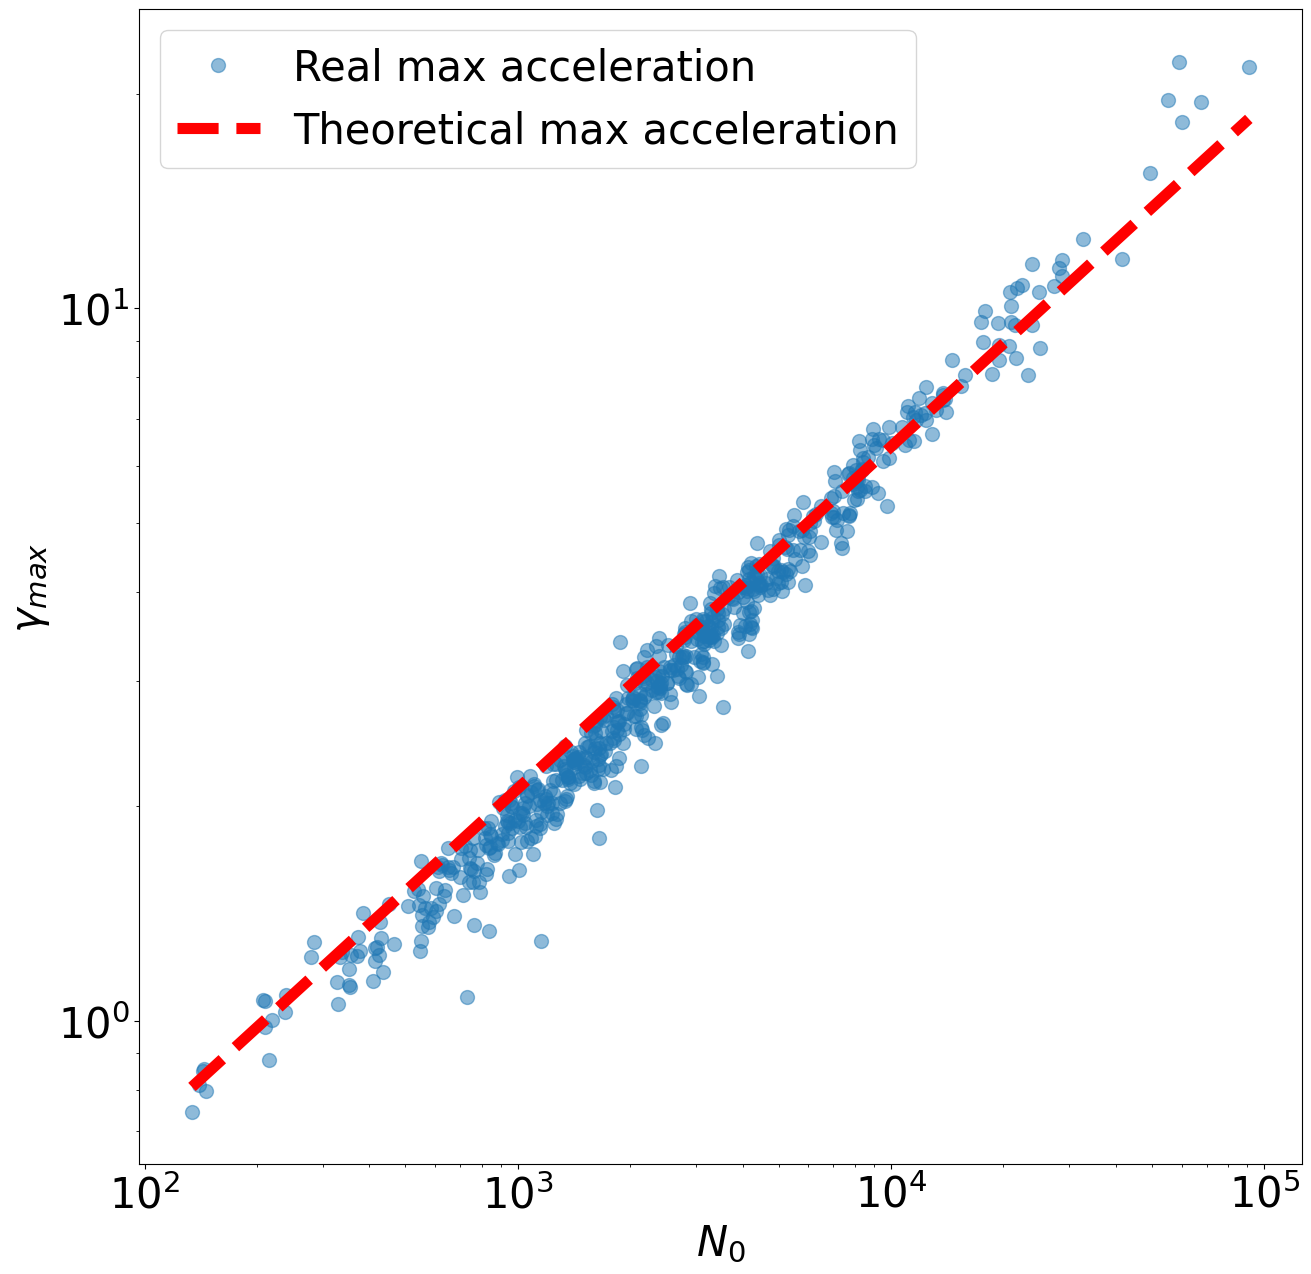

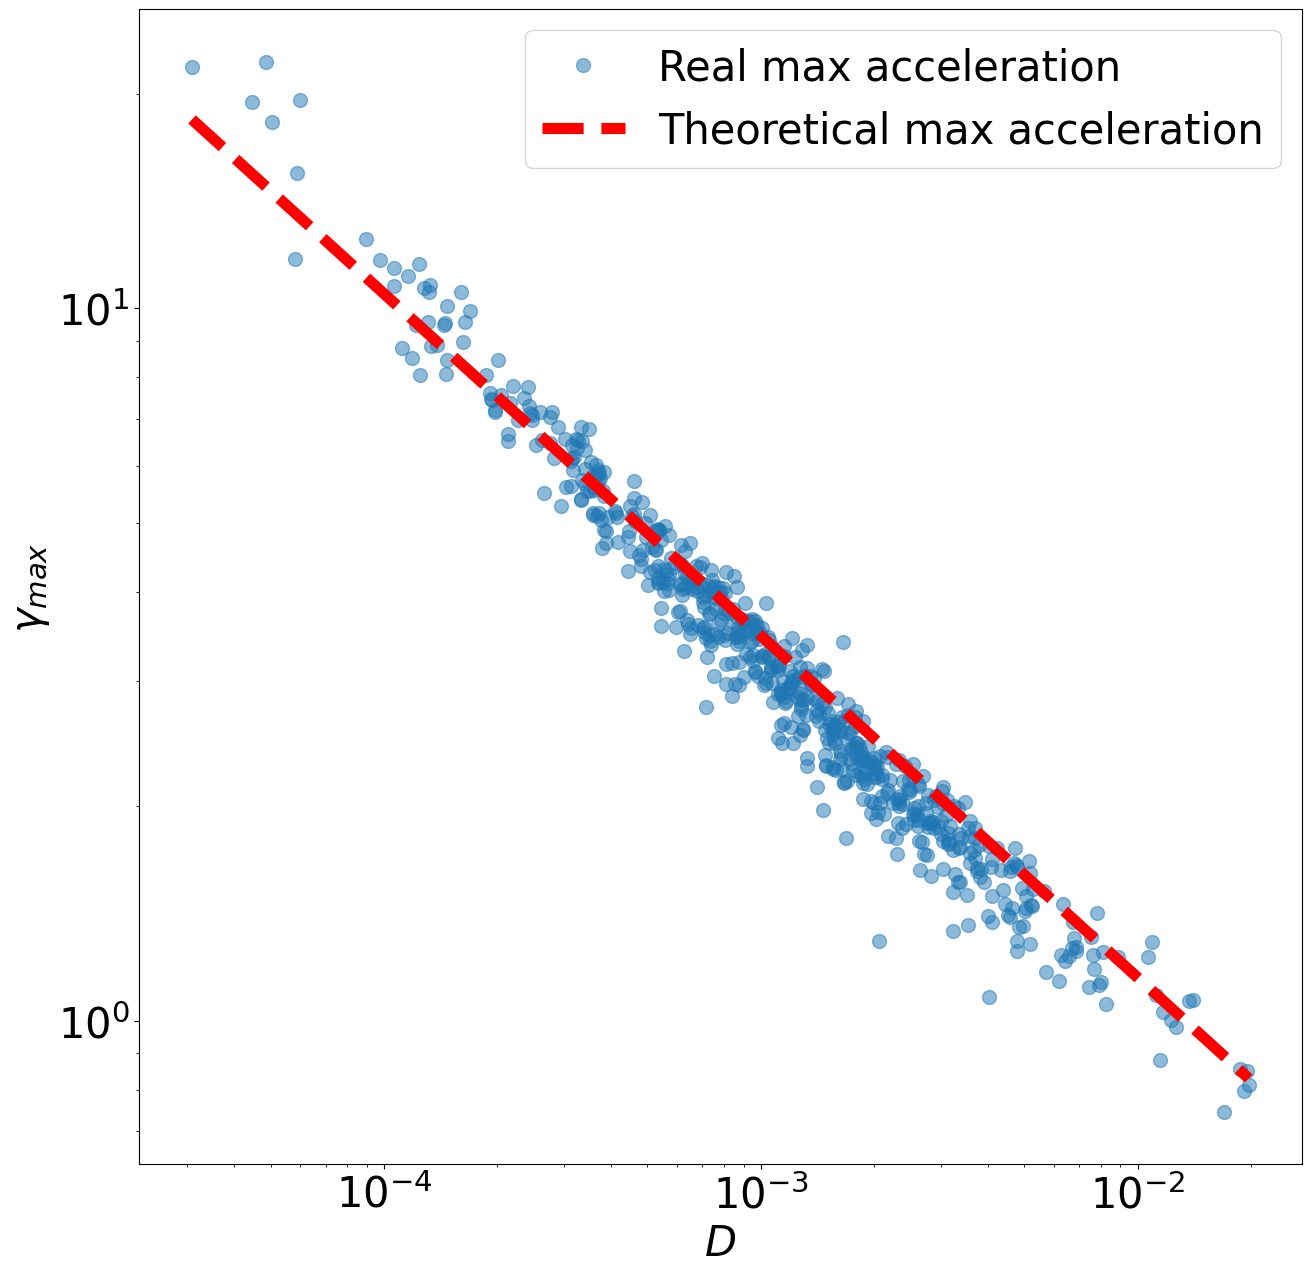

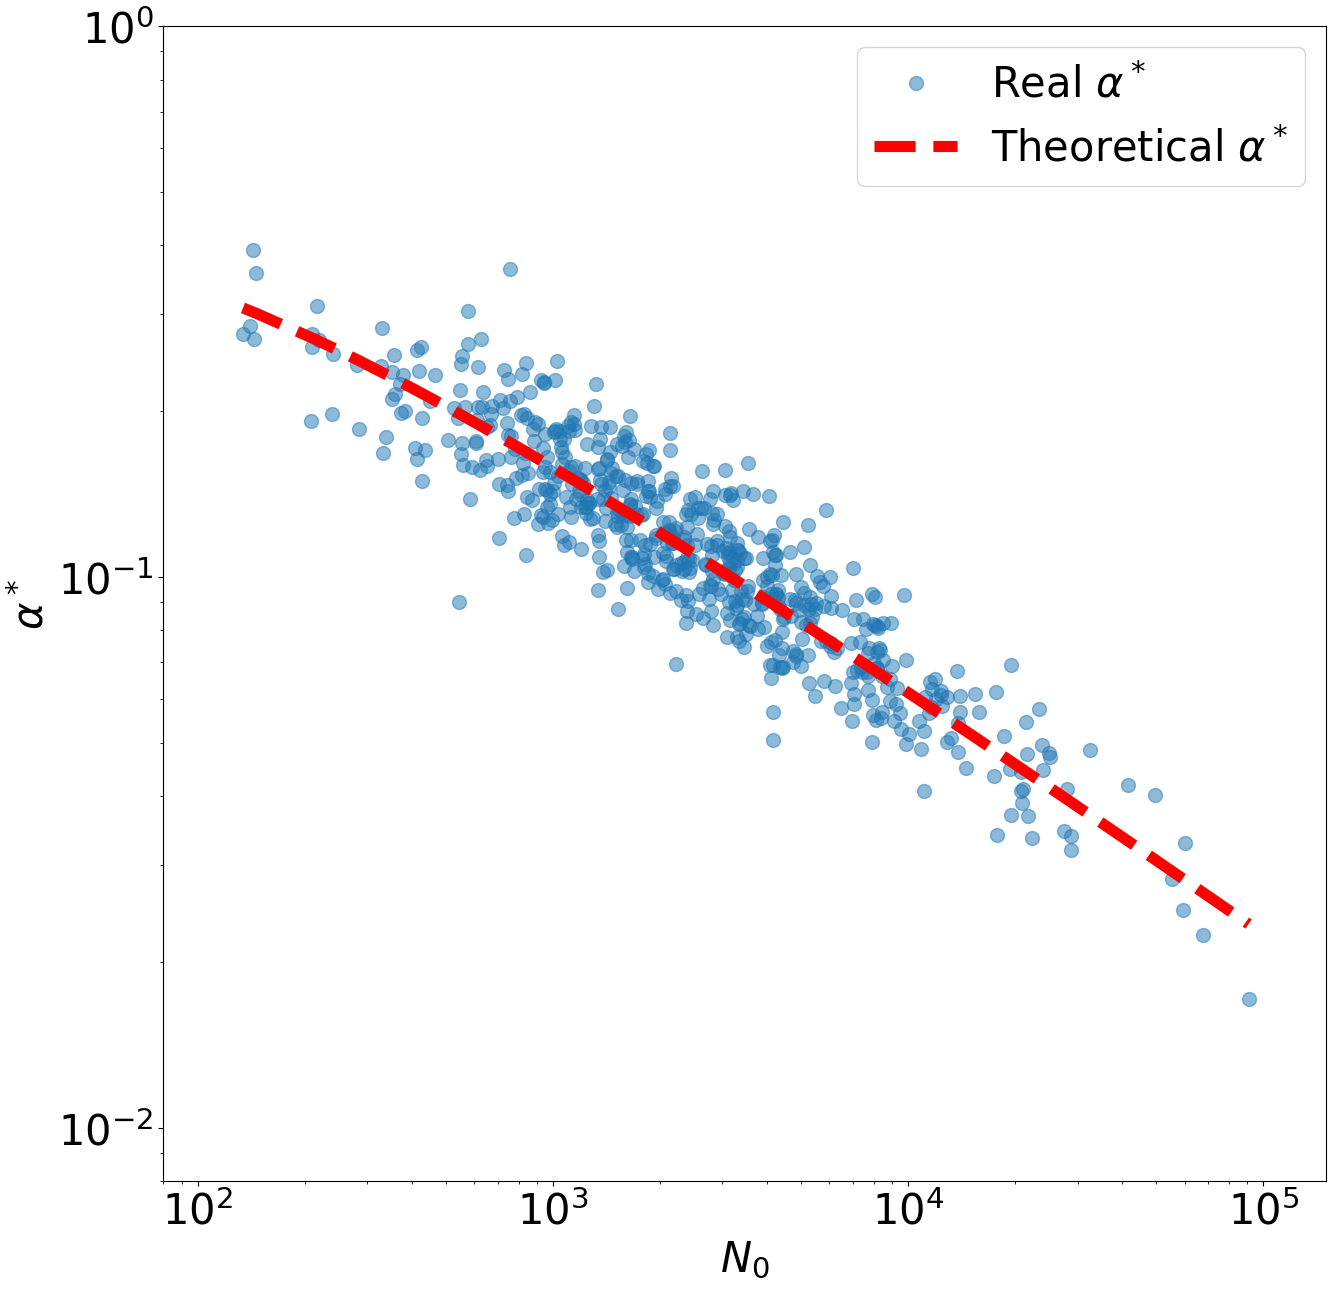

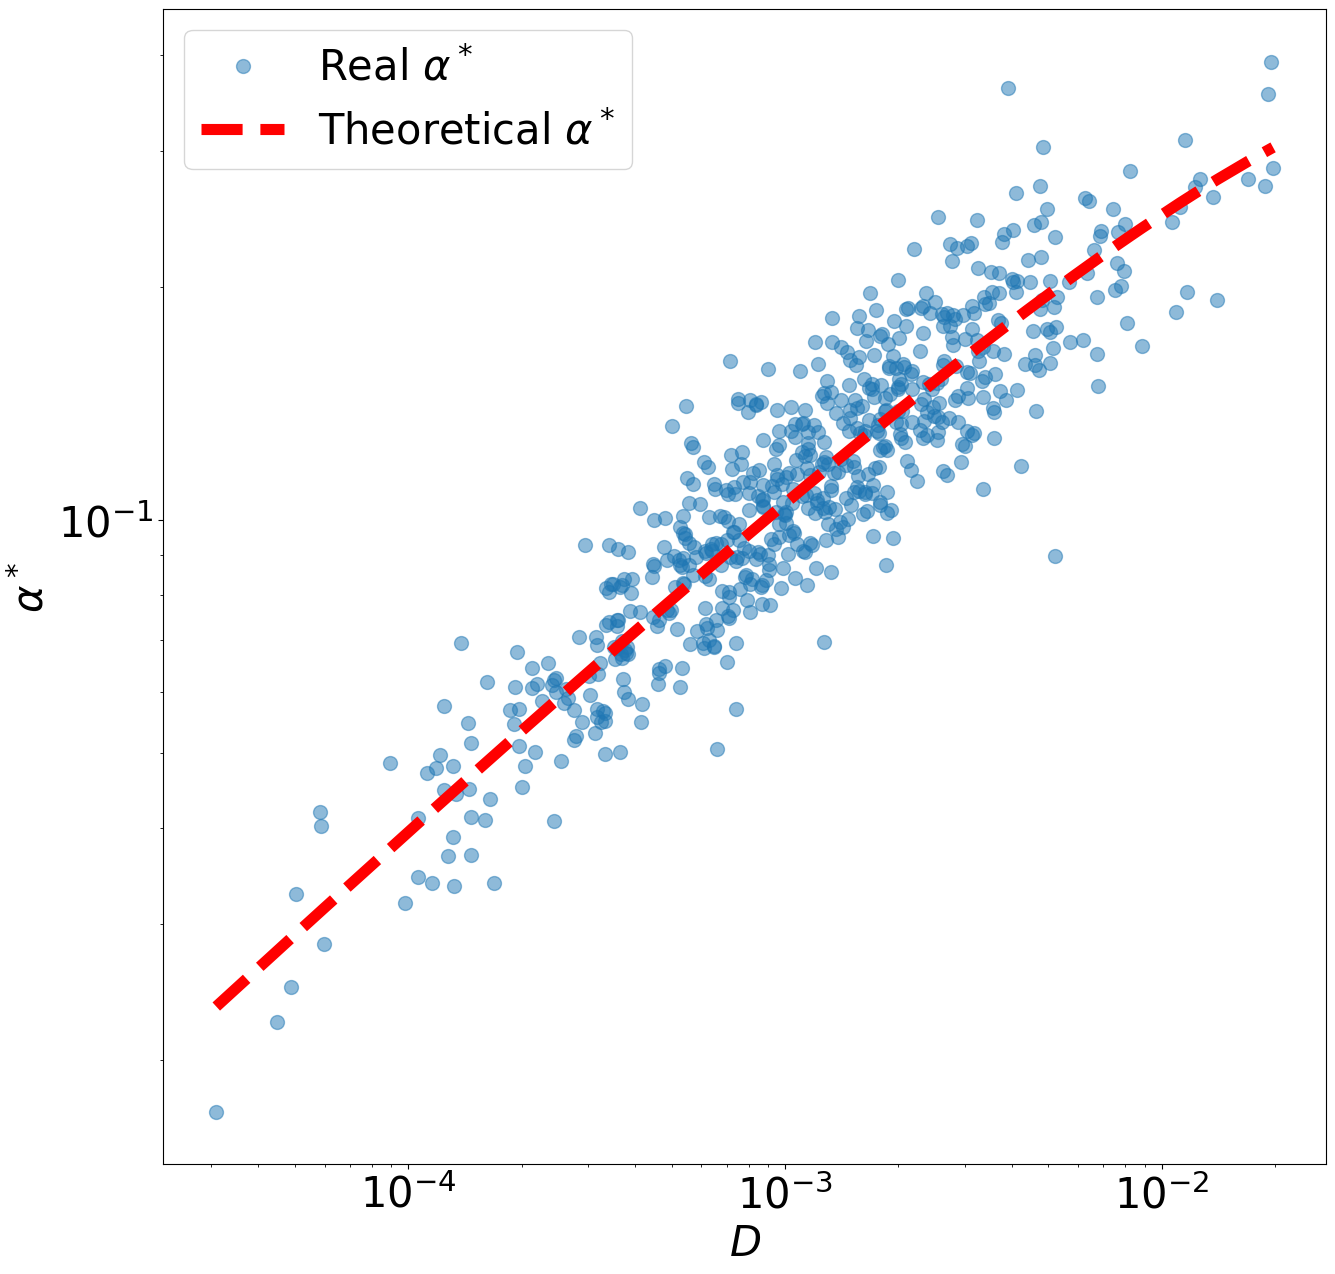

In [28]:
plot_loglog(
    x_data=nodes,
    y_data=speed_up_opt,
    theoretical_curve=theoretical_max_acceleration_nodes,
    x_label=r'$N_0$',
    y_label=r'$\gamma_{max}$',
    legend_real='Real max acceleration',
    legend_theoretical='Theoretical max acceleration'
)

plot_loglog(
    x_data=density,
    y_data=speed_up_opt,
    theoretical_curve=theoretical_max_acceleration_density,
    x_label=r'$D$',
    y_label=r'$\gamma_{max}$',
    legend_real='Real max acceleration',
    legend_theoretical='Theoretical max acceleration'
)

plot_loglog(
    x_data=nodes,
    y_data=alpha_opt,
    theoretical_curve=theoretical_alpha_star_nodes,
    x_label=r'$N_0$',
    y_label=r'$\alpha^*$',
    legend_real=r'Real $\alpha^*$',
    legend_theoretical=r'Theoretical $\alpha^*$',
    y_limits=[10**-2 * 0.8, 1],
    x_limits=[80, 150000]
)

plot_loglog(
    x_data=density,
    y_data=alpha_opt,
    theoretical_curve=theoretical_alpha_star_density,
    x_label=r'$D$',
    y_label=r'$\alpha^*$',
    legend_real=r'Real $\alpha^*$',
    legend_theoretical=r'Theoretical $\alpha^*$'
)